### Basic Concepts: Nodes, Edges & State

In [6]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [7]:
from typing import TypedDict
from pydantic import BaseModel
from langgraph.graph import START, END, StateGraph

class state (TypedDict):
    string_value: str
    numeric_value: int

class state_pydantic(BaseModel):
    string_value: str
    numeric_value: int

In [8]:
def modify (input: state):
    input["string_value"] = input["string_value"].upper()
    input["numeric_value"] += 1

    return input

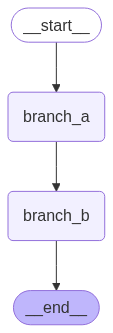

In [9]:
# def modify (input: state):
#     print(f"Current value: {input}")
#     return input

graph = StateGraph (state)

graph.add_node ("branch_a", modify)
graph.add_node ("branch_b", modify)

graph.add_edge (START, "branch_a")
graph.add_edge ("branch_a", "branch_b")
graph.add_edge ("branch_b", END)

graph.add_edge (START, "branch_a")

run = graph.compile()

run

In [10]:
run.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'A', 'numeric_value': 3}

In [11]:
run.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'A', 'numeric_value': 3}

In [12]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [13]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

'numeric_value'


In [14]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Why not use just LCEL?

In [15]:
from langchain_core.runnables import RunnableLambda

In [16]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable
chain

RunnableLambda(modify_state)
| RunnableLambda(modify_state)

In [17]:
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

In [18]:
runnable = RunnableLambda(modify_state)
runnable1 = RunnableLambda(modify)

chain = runnable | runnable1
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'AA', 'numeric_value': 3}

### Cycles and Conditional Edges

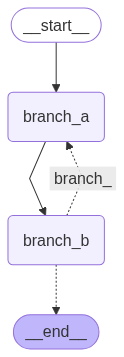

In [19]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 2
    print ( f" modify_state: Current value: {input}")
    return input

def modify_brach_b(input: InputState):
    input["string_value"] += "b"
    input["numeric_value"] -= 1
    print(f" modify: Current value: {input}")
    return input


def router(input: InputState):
    if input["numeric_value"] < 8:
        return "branch_"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_brach_b)
graph.add_edge("branch_a", "branch_b")
graph.add_conditional_edges(
    "branch_b", router, {"branch_": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()
runnable

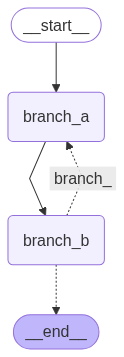

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [21]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

 modify_state: Current value: {'string_value': 'aa', 'numeric_value': 3}
 modify: Current value: {'string_value': 'aab', 'numeric_value': 2}
 modify_state: Current value: {'string_value': 'aaba', 'numeric_value': 4}
 modify: Current value: {'string_value': 'aabab', 'numeric_value': 3}
 modify_state: Current value: {'string_value': 'aababa', 'numeric_value': 5}
 modify: Current value: {'string_value': 'aababab', 'numeric_value': 4}
 modify_state: Current value: {'string_value': 'aabababa', 'numeric_value': 6}
 modify: Current value: {'string_value': 'aabababab', 'numeric_value': 5}
 modify_state: Current value: {'string_value': 'aababababa', 'numeric_value': 7}
 modify: Current value: {'string_value': 'aababababab', 'numeric_value': 6}
 modify_state: Current value: {'string_value': 'aabababababa', 'numeric_value': 8}
 modify: Current value: {'string_value': 'aabababababab', 'numeric_value': 7}
 modify_state: Current value: {'string_value': 'aababababababa', 'numeric_value': 9}
 modify: 

{'string_value': 'aababababababab', 'numeric_value': 8}

In [42]:
from langgraph.graph import StateGraph, END, START
from pydantic import BaseModel
from typing import TypedDict
from typing import Annotated
from operator import add

class input_state(TypedDict):
	string_value: Annotated[str, add]
	numeric_value: Annotated[int, add]
# class input_state(TypedDict):
#     string_value: str
#     numeric_value: int

def mod_a (input : input_state):
    input["string_value"] += "a"
    input["numeric_value"] += 2
    print (f" mod_a: Current value: {input}")
    return input

def mod_b (input : input_state):
    input["string_value"] += "b"
    input["numeric_value"] -= 1
    print(f" mod_b: Current value: {input}")
    return input

def mod_c (input : input_state):
    input["string_value"] += "c"
    input["numeric_value"] += 3
    print(f" mod_c: Current value: {input}")
    return input

In [50]:
def route_b_a (input: input_state):
    if input["numeric_value"] < 8:
        return "branch_a"
    else:
        return "branch_two"
    
def route_c_b (input: input_state):
    if input["numeric_value"] < 10:
        return "branch_b"
    else:
        return END

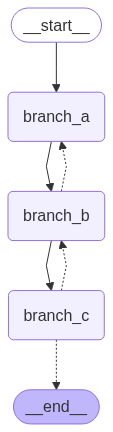

In [51]:
graph = StateGraph (input_state)

graph.add_node ("branch_a", mod_a)
graph.add_node ("branch_b", mod_b)
graph.add_node ("branch_c", mod_c)

graph.add_edge (START, "branch_a")
graph.add_edge ("branch_a", "branch_b")
graph.add_edge ("branch_b", "branch_c")
graph.add_edge ("branch_c", END)

graph.add_conditional_edges(
    "branch_b", route_b_a, {"branch_a":"branch_a", "branch_two":"branch_c"}
    
)

graph.add_conditional_edges(
    "branch_c", route_c_b, {"branch_b":"branch_b", END: END}
)

run = graph.compile()
run

In [52]:
run.invoke({"string_value": "a", "numeric_value": 1})

 mod_a: Current value: {'string_value': 'aa', 'numeric_value': 3}
 mod_b: Current value: {'string_value': 'aaab', 'numeric_value': 3}
 mod_a: Current value: {'string_value': 'aaaaaaba', 'numeric_value': 9}
 mod_c: Current value: {'string_value': 'aaaaaabc', 'numeric_value': 10}
 mod_b: Current value: {'string_value': 'aaaaaabaaaaaabaaaaaaabcb', 'numeric_value': 25}
 mod_c: Current value: {'string_value': 'aaaaaabaaaaaabaaaaaaabcaaaaaabaaaaaabaaaaaaabcbc', 'numeric_value': 54}


{'string_value': 'aaaaaabaaaaaabaaaaaaabcaaaaaabaaaaaabaaaaaaabcbaaaaaabaaaaaabaaaaaaabcaaaaaabaaaaaabaaaaaaabcbc',
 'numeric_value': 105}

### Reducer functions

In [67]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [68]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [69]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

### Alternative State

In [ ]:
from typing import TypedDict
from langgraph.graph import END, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


# class InputState(BaseModel):
#       string_value: str
#       numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"]
    # string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
runnable.invoke({"string_value": "a", "numeric_value": "a"})

a
a


{'string_value': 'a', 'numeric_value': 'a'}